<a href="https://colab.research.google.com/github/Latamila/SeriesTemporais_BolsadeValores_Yahoo/blob/main/Indicadores_Financeiros_Trimestre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PREVENDO INIDICADORES FINANCEIROS POR TRIMESTRE

---

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.10.12


In [5]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.4 MB/s eta 0:00:00


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Imports
import pandas as pd
import numpy as np
import sklearn
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

numpy     : 1.23.5
pandas    : 1.5.3
tensorflow: 2.15.0
matplotlib: 3.7.1
sklearn   : 1.2.2



In [8]:
# Carrega o dataset
df_dsa = pd.read_csv('dataset.csv')

In [9]:
# Shape dos dados
df_dsa.shape

(63, 8)

In [10]:
# Visualiza os 5 primeiros registros
df_dsa.head()

,meses,receita_total_ops,custo_func,depreciacao,outras_despesas,outras_receitas,juros,lucro_ou_prejuizo_liquido_do_periodo
0,2023-06,1388.12,92.33,153.50,284.64,1528.18,784.27,194.15
1,2023-03,1383.82,86.93,152.50,304.13,1458.58,744.37,191.85
2,2022-12,1378.24,70.64,152.10,909.83,428.06,650.46,11.40
3,2022-09,1220.58,59.75,154.74,1339.39,514.67,632.22,-298.18
4,2022-06,1254.51,77.38,153.64,1564.59,597.48,653.34,-384.50


In [11]:
# Ordena os dados pela coluna que representa o tempo (isso é importante devido ao modelo que iremos usar)
df_dsa = df_dsa.sort_values("meses")

In [12]:
# Reset do índice (sempre que fizer qualquer alteração no dataframe)
df_dsa = df_dsa.reset_index(drop = True)

In [13]:
# Definindo as variáveis que serão usadas para as previsões (variáveis de índice 1 a 8)
cols = list(df_dsa)[1:8]

In [14]:
# Visualiza as colunas
print(cols)

['receita_total_ops', 'custo_func', 'depreciacao', 'outras_despesas', 'outras_receitas', 'juros', 'lucro_ou_prejuizo_liquido_do_periodo']


In [15]:
# Converte as variáveis para o tipo float a fim de aumentar a precisão dos cálculos e cria o dataframe de treino
df_treino = df_dsa[cols].astype(float)

In [16]:
# Visualiza os 5 primeiros registros
df_treino.head()

,receita_total_ops,custo_func,depreciacao,outras_despesas,outras_receitas,juros,lucro_ou_prejuizo_liquido_do_periodo
0,205.35,6.22,26.89,56.44,4.65,30.67,52.44
1,328.65,8.71,29.15,59.46,20.91,31.95,91.10
2,253.73,8.61,31.16,45.64,20.04,39.60,96.80
3,296.00,8.73,32.18,64.05,7.78,55.18,112.28
4,300.89,8.91,34.75,87.28,2.39,49.51,100.81


In [17]:
# Visualiza os 5 últimos registros
df_treino.tail()

,receita_total_ops,custo_func,depreciacao,outras_despesas,outras_receitas,juros,lucro_ou_prejuizo_liquido_do_periodo
58,1254.51,77.38,153.64,1564.59,597.48,653.34,-384.50
59,1220.58,59.75,154.74,1339.39,514.67,632.22,-298.18
60,1378.24,70.64,152.10,909.83,428.06,650.46,11.40
61,1383.82,86.93,152.50,304.13,1458.58,744.37,191.85
62,1388.12,92.33,153.50,284.64,1528.18,784.27,194.15


#PRE PROCESSAMENTO DA SERIE TEMPORAL MULTIVARIADA

---

In [18]:
# Cria o padronizador
scaler = StandardScaler()

In [19]:
# Treina o padronizador
scaler = scaler.fit(df_treino)

In [20]:
# Aplica o padronizador aos dados
df_treino_scaled = scaler.transform(df_treino)

In [21]:
# Cria listas vazias para X e Y
x_treino = []
y_treino = []

In [22]:
# Número de passos no tempo que queremos olhar para o futuro a fim de fazer previsões
# Estamos trabalhando com uma série trimestral, logo: 1 passo = 1 trimestre
n_futuro = 1

In [23]:
# Número de passos anteriores que queremos usar para prever o futuro
n_past = 15

In [24]:
# Loop pelos dados padronizados para gerar as listas de dados para X e Y
for i in range(n_past, len(df_treino_scaled) - n_futuro + 1):

    # Carrega x
    x_treino.append(df_treino_scaled[i - n_past : i, :])

    # Carrega y
    y_treino.append(df_treino_scaled[i + n_futuro - 1 : i + n_futuro, 0])

In [25]:
# Converte as listas para array numpy
x_treino, y_treino = np.array(x_treino), np.array(y_treino)

In [26]:
# Tamanho do array
len(x_treino)

48

In [27]:
# Tamanho do array
len(y_treino)

48

In [28]:
# Shape de x
x_treino.shape

(48, 15, 7)

In [29]:
# Shape de y
y_treino.shape

(48, 1)

#CONSTRUÇÃO DO MODELO DE IA

---



In [30]:
# Cria a sequência de camadas da rede neural artificial
modelo_dsa = Sequential()

In [31]:
# Adiciona a camada LSTM com 128 neurônios, ativação sigmóide e somente uma sequência LSTM
modelo_dsa.add(LSTM(128,
                    activation = "sigmoid",
                    input_shape = (x_treino.shape[1], x_treino.shape[2]),
                    return_sequences = False))

In [32]:
# Adiciona a camada densa de saída
modelo_dsa.add(Dense(y_treino.shape[1]))

In [33]:
# Compila o modelo com otimizador ADAM e função de erro mean_squared_error
modelo_dsa.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [34]:
# Sumário do modelo
modelo_dsa.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 69761 (272.50 KB)
Trainable params: 69761 (272.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#TREINAMENTO DO MODELO

---

In [35]:
# Definimos os hiperparâmetros
batch = 16
num_epochs = 10
split = 0.1

In [36]:
# Treinamento do modelo
history = modelo_dsa.fit(x_treino,
                         y_treino,
                         epochs = num_epochs,
                         batch_size = batch,
                         validation_split = split,
                         verbose = 2)

Epoch 1/10
3/3 - 2s - loss: 0.9094 - val_loss: 0.1848 - 2s/epoch - 758ms/step
Epoch 2/10
3/3 - 0s - loss: 0.4656 - val_loss: 0.0307 - 126ms/epoch - 42ms/step
Epoch 3/10
3/3 - 0s - loss: 0.5797 - val_loss: 0.0284 - 119ms/epoch - 40ms/step
Epoch 4/10
3/3 - 0s - loss: 0.5258 - val_loss: 0.0541 - 108ms/epoch - 36ms/step
Epoch 5/10
3/3 - 0s - loss: 0.4280 - val_loss: 0.1454 - 141ms/epoch - 47ms/step
Epoch 6/10
3/3 - 0s - loss: 0.4524 - val_loss: 0.2226 - 116ms/epoch - 39ms/step
Epoch 7/10
3/3 - 0s - loss: 0.4520 - val_loss: 0.1516 - 100ms/epoch - 33ms/step
Epoch 8/10
3/3 - 0s - loss: 0.4097 - val_loss: 0.0851 - 112ms/epoch - 37ms/step
Epoch 9/10
3/3 - 0s - loss: 0.3903 - val_loss: 0.0459 - 119ms/epoch - 40ms/step
Epoch 10/10
3/3 - 0s - loss: 0.3812 - val_loss: 0.0446 - 113ms/epoch - 38ms/step


#AVALIAÇÃO DO MODELO

---

In [37]:
# Extrai as previsões com os dados de treino
previsoes_treino = modelo_dsa.predict(x_treino)

2/2 [==============================] - 1s 17ms/step


In [38]:
# Visualiza as previsões
previsoes_treino

array([[-0.07451367],
       [-0.03665575],
       [-0.00273805],
       [ 0.00203976],
       [ 0.06280634],
       [ 0.08093034],
       [ 0.13065849],
       [ 0.16714613],
       [ 0.32639357],
       [ 0.30768865],
       [ 0.28841722],
       [ 0.25843948],
       [ 0.27815104],
       [ 0.35844943],
       [ 0.3761601 ],
       [ 0.3596149 ],
       [ 0.4080366 ],
       [ 0.563145  ],
       [ 0.4894382 ],
       [ 0.45350933],
       [ 0.4864234 ],
       [ 0.56419706],
       [ 0.576607  ],
       [ 0.63972443],
       [ 0.6740118 ],
       [ 0.6621269 ],
       [ 0.6527338 ],
       [ 0.69724345],
       [ 0.549797  ],
       [ 0.6245536 ],
       [ 0.7360643 ],
       [ 0.7899567 ],
       [ 0.69816273],
       [ 0.6411226 ],
       [ 0.68647516],
       [ 0.6797912 ],
       [ 0.6842926 ],
       [ 0.7984703 ],
       [ 0.8200652 ],
       [ 0.7539364 ],
       [ 0.69989747],
       [ 0.7698078 ],
       [ 0.7894224 ],
       [ 0.6360873 ],
       [ 0.6167035 ],
       [ 0

#FORECAST MANUAL

___

In [39]:
# Número de passos para prever (1 passo = 1 trimestre)
num_passos_prever = 1

In [40]:
# Obtém a última sequência de dados
last_sequence = df_treino_scaled[-n_past:]

In [41]:
last_sequence.shape

(15, 7)

In [42]:
# Array de 15 elementos com 7 colunas em cada elemento
last_sequence

array([[ 0.51806968,  0.61570094,  0.73706718,  0.30613841,  0.69866005,
         0.75337373,  0.23080801],
       [ 0.5234785 ,  0.67366976,  1.17935038,  3.2147001 ,  2.59402345,
         0.41440622,  0.37028038],
       [-0.39136821,  0.850404  ,  1.13621236, -0.2813359 ,  0.75576234,
         0.91471108, -0.35038305],
       [ 0.27998704,  0.93617902,  1.16963247, -1.49222164,  0.81242036,
         1.24220056,  1.02930079],
       [ 0.80721727,  0.97011199,  1.17484696, -0.58946294,  0.85418085,
         1.45843475,  0.78256015],
       [ 0.54057889,  0.7151434 ,  1.11203611, -0.03663262,  0.4589667 ,
         1.65975179, -0.22729936],
       [ 0.58434547,  0.92722448,  1.18053549,  1.04809726,  0.57995365,
         1.11091244, -0.68146131],
       [ 0.29902421,  1.15674334,  1.16844736, -0.13785804,  0.98603736,
         1.53022622, -0.20821296],
       [ 0.27183838,  0.85323175,  1.12175401, -0.0549771 ,  1.34494062,
         1.65446415,  0.3132235 ],
       [ 0.22287555,  0.7943

In [43]:
# Ajusta o shape para obter os dados de 1 indicador
last_sequence = np.reshape(last_sequence, (1, n_past, len(cols)))

In [44]:
last_sequence.shape

(1, 15, 7)

In [45]:
last_sequence

array([[[ 0.51806968,  0.61570094,  0.73706718,  0.30613841,
          0.69866005,  0.75337373,  0.23080801],
        [ 0.5234785 ,  0.67366976,  1.17935038,  3.2147001 ,
          2.59402345,  0.41440622,  0.37028038],
        [-0.39136821,  0.850404  ,  1.13621236, -0.2813359 ,
          0.75576234,  0.91471108, -0.35038305],
        [ 0.27998704,  0.93617902,  1.16963247, -1.49222164,
          0.81242036,  1.24220056,  1.02930079],
        [ 0.80721727,  0.97011199,  1.17484696, -0.58946294,
          0.85418085,  1.45843475,  0.78256015],
        [ 0.54057889,  0.7151434 ,  1.11203611, -0.03663262,
          0.4589667 ,  1.65975179, -0.22729936],
        [ 0.58434547,  0.92722448,  1.18053549,  1.04809726,
          0.57995365,  1.11091244, -0.68146131],
        [ 0.29902421,  1.15674334,  1.16844736, -0.13785804,
          0.98603736,  1.53022622, -0.20821296],
        [ 0.27183838,  0.85323175,  1.12175401, -0.0549771 ,
          1.34494062,  1.65446415,  0.3132235 ],
        [ 

In [46]:
# Faz a previsão de 1 indicador em um passo no tempo
previsao = modelo_dsa.predict(last_sequence)

1/1 [==============================] - 0s 44ms/step


In [47]:
# Visualiza a previsão de 1 indicador
previsao

array([[1.0497683]], dtype=float32)

In [48]:
# Agora extrai as previsões para todos os indicadores (por isso shape 1, número de colunas)
previsoes_todos_indicadores = np.repeat(previsao, df_treino.shape[1], axis = -1)

In [49]:
# Previsão de todos os indicadores em 1 passo no tempo (1 trimestre)
previsoes_todos_indicadores

array([[1.0497683, 1.0497683, 1.0497683, 1.0497683, 1.0497683, 1.0497683,
        1.0497683]], dtype=float32)

#INVERTER A TRANSFORMAÇÃO FEITA NA PADRONIZAÇÃO DOS DADOS

___

In [50]:
# Inverte a transformação feita na padronização dos dados
y_pred_futuro = scaler.inverse_transform(previsoes_todos_indicadores)[:,:]

In [51]:
y_pred_futuro


array([[1407.8718  ,   62.610172,  150.64291 ,  686.7557  ,  677.8081  ,
         519.1368  ,  701.78955 ]], dtype=float32)

In [52]:
print("Valores Previstos dos Indicadores Para o Próximo Passo no Tempo:\n", y_pred_futuro[0])

Valores Previstos dos Indicadores Para o Próximo Passo no Tempo:
 [1407.8718     62.610172  150.64291   686.7557    677.8081    519.1368
  701.78955 ]


#AUTOMATIZANDO O FORECAST PARA JANELA DE 1 ANO DE PREVISÃO

---

In [53]:
# Função com todas as etapas feitas anteriormente para automatizar o processo de forecast
def automatiza_forecast(df_para_treinar_modelo):

    scaler = StandardScaler()

    scaler = scaler.fit(df_para_treinar_modelo)

    df_para_treinar_modelo_scaled = scaler.transform(df_para_treinar_modelo)

    x_treino = []

    y_treino = []

    n_futuro = 1

    n_past = 15

    for i in range(n_past, len(df_para_treinar_modelo_scaled) - n_futuro + 1):
        x_treino.append(df_para_treinar_modelo_scaled[i - n_past:i, :])
        y_treino.append(df_para_treinar_modelo_scaled[i + n_futuro - 1:i + n_futuro, 0])

    x_treino, y_treino = np.array(x_treino), np.array(y_treino)

    modelo_dsa = Sequential()

    modelo_dsa.add(LSTM(128,
                        activation = "sigmoid",
                        input_shape = (x_treino.shape[1], x_treino.shape[2]),
                        return_sequences = False))

    modelo_dsa.add(Dense(y_treino.shape[1]))

    modelo_dsa.compile(optimizer = 'adam', loss = 'mean_squared_error')

    history = modelo_dsa.fit(x_treino, y_treino, epochs = 10, batch_size = 16, validation_split = 0.1, verbose = 0)

    n_past = 15

    last_sequence = df_para_treinar_modelo_scaled[-n_past:]

    last_sequence = np.reshape(last_sequence, (1, n_past, len(cols)))

    previsao = modelo_dsa.predict(last_sequence)

    previsao_indicadores = np.repeat(previsao, df_para_treinar_modelo.shape[1], axis = -1)

    y_pred_futuro = scaler.inverse_transform(previsao_indicadores)[:,0]

    return y_pred_futuro[0]

In [55]:
# Carrega e organiza os dados
df = pd.read_csv('dataset.csv')
df = df.sort_values("meses")
df = df.reset_index(drop = True)
cols = list(df)[1:8]
previsoes_1_ano = {}

In [56]:
# Iterando através de cada coluna e aplicando a função de automação
for column in cols:

    # Seleciona a coluna atual como coluna de destino
    target_column = column

    # Novo dataframe com coluna de destino como primeira coluna
    df_treino = df[[target_column] + [col for col in cols if col != target_column]].astype(float)

    # Aplica a função e extrai a previsão
    pred = automatiza_forecast(df_treino)

    # Target
    previsoes_1_ano[target_column] = round(pred, 2)

1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 185ms/step


In [57]:
# Vamos concatenar as previsões com o dataset original
df_previsoes_1_ano = pd.DataFrame([previsoes_1_ano])
df_previsoes_1_ano["meses"] = '2023-09'
df_combined = pd.concat([df, df_previsoes_1_ano], ignore_index = True)
df_combined = df_combined.reset_index(drop = True)

In [59]:
# Salva o arquivo em disco
df_combined.to_csv("previsao_1_ano.csv", index = False)

VISUALIZANDO O FORECAST DE CADA INDICADOR

---

In [60]:
# Carrega o dataset com as previsões
df = pd.read_csv("previsao_1_ano.csv")

In [61]:
df.tail()


,meses,receita_total_ops,custo_func,depreciacao,outras_despesas,outras_receitas,juros,lucro_ou_prejuizo_liquido_do_periodo
59,2022-09,1220.58000,59.750000,154.740000,1339.390000,514.670000,632.220000,-298.180000
60,2022-12,1378.24000,70.640000,152.100000,909.830000,428.060000,650.460000,11.400000
61,2023-03,1383.82000,86.930000,152.500000,304.130000,1458.580000,744.370000,191.850000
62,2023-06,1388.12000,92.330000,153.500000,284.640000,1528.180000,784.270000,194.150000
63,2023-09,1322.02002,67.919998,164.080002,435.089996,728.710022,637.849976,384.640015


In [62]:
# Define a função que aceita um DataFrame pandas como argumento.
def plot_forecast(df):

    # Remove a primeira coluna do DataFrame.
    df = df.iloc[:, 1:]

    # Define o número de colunas na grid de gráficos.
    num_cols = 3

    # Calcula o número de linhas necessárias na grid.
    num_rows = (len(df.columns) - 1) // num_cols + 1

    # Define o tamanho total da figura.
    figsize = (num_cols * 6, num_rows * 4)

    # Cria a figura e os eixos para os subgráficos.
    fig, axes = plt.subplots(num_rows, num_cols, figsize = figsize)

    # Achata o array 2D de eixos para um array 1D para facilitar a iteração.
    axes = axes.flatten()

    # Itera através das colunas do DataFrame.
    for i, col in enumerate(df.columns):

        # Pega o i-ésimo eixo para o i-ésimo gráfico.
        ax = axes[i]

        # Usa o índice do DataFrame como os valores do eixo X.
        x_values = df.index

        # Usa os valores da coluna atual como os valores do eixo Y.
        y_values = df[col]

        # Plota os valores de X e Y.
        ax.plot(x_values, y_values)

        # Define o título do gráfico para o nome da coluna atual.
        ax.set_title(col)

        # Define o rótulo do eixo X.
        ax.set_xlabel('Trimestres')

        # Define o rótulo do eixo Y.
        ax.set_ylabel('Valor')

        # Ativa a grade no gráfico.
        ax.grid(True)

        # Gira os rótulos do eixo X em 45 graus.
        ax.tick_params(axis = 'x', rotation = 45)

        # Remove os rótulos do eixo X.
        ax.set_xticklabels([])

    # Verifica se há mais eixos do que colunas.
    if len(df.columns) < len(axes):

        # Itera pelos eixos excedentes.
        for j in range(len(df.columns), len(axes)):

            # Remove os eixos excedentes.
            fig.delaxes(axes[j])

    # Ajusta o layout para que os gráficos não se sobreponham.
    fig.tight_layout()

    # Exibe a figura completa.
    plt.show()

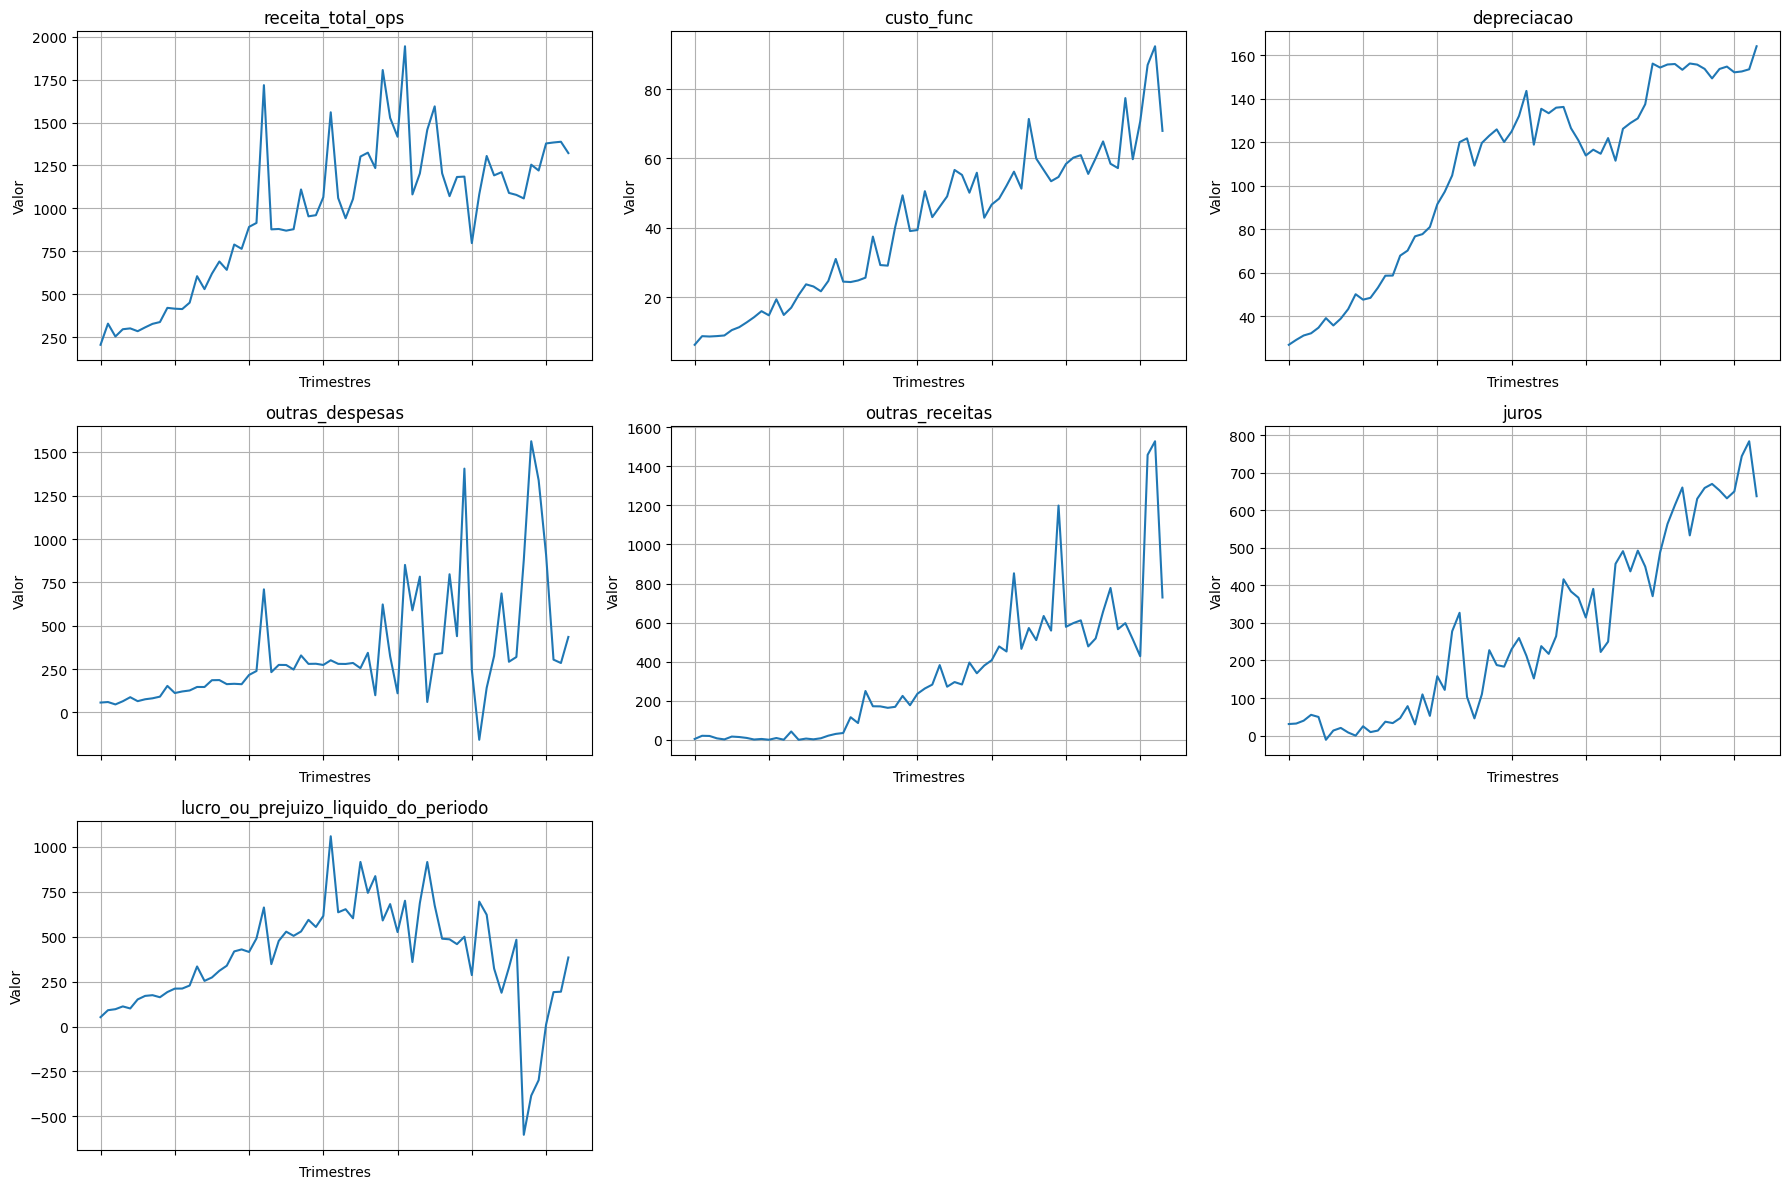

In [63]:
# Executa a função
plot_forecast(df)